The idea is to implement here an architecture similar to the one developed in "Datadriven wind turbine wake modeling via probabilistic Machine Learning":
- autoencoder trained on the output wake field
- MLP from input to latent space which is then plugged to the trained decoder to obtain the actual desired output

In [274]:
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
from collections import defaultdict
import time
import matplotlib.pyplot as plt
#import seaborn as sns
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from data_loaders import get_wake_dataloader

# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)

In [275]:
from torchvision import transforms
import torchvision

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset.transform = train_transform

batch_size=256

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
tensor = train_dataset[0][0]
print(tensor.shape)
print(tensor.squeeze(0).shape)

torch.Size([1, 28, 28])
torch.Size([28, 28])


In [276]:
DATAFRAME_FILEPATH = "data/wake_dataframe_0.25diam.csv"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

# hyperparameters
BATCH_SIZE = 2
LR = 1e-2
WD = 1e-5 # weight decay
EPOCHS = 500

LATENT_SPACE = 5

In [277]:
INPUT_VARIABLES = ['ws', 'TI', 'ct']
OUTPUT_VARIABLES = ['WS_eff', 'TI_eff', 'P']

#TODO split in training and test sets
train_dataloader = get_wake_dataloader(DATAFRAME_FILEPATH, INPUT_VARIABLES, OUTPUT_VARIABLES, MinMaxScaler(), BATCH_SIZE)
len(train_dataloader)
train_dataloader.dataset.y.shape

/Users/niccolomorabito/Library/CloudStorage/GoogleDrive-morabito.1808746@studenti.uniroma1.it/My Drive/BDMA/Semester4 Thesis/Ainslie-surrogate/data_loaders.py:45: UserWarning: Currently, only one output feature (WS_eff) is considered in multivariate setting, the others are ignored
  warnings.warn("Currently, only one output feature (WS_eff) is considered in multivariate setting, the others are ignored") #TODO


torch.Size([69, 192, 8])

In [278]:
class AutoEncoder(nn.Module):

    def __init__(self, field_shape: int):
        super(AutoEncoder, self).__init__()
        self.field_shape = field_shape
        
        self.encoder = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(field_shape[0] * field_shape[1], 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, field_shape[0] * field_shape[1]),
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(field_shape[0], field_shape[1]))
        )
    
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode
    

Link for Convolutional Autoencoder https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac

In [283]:
class UnsqueezeForChannel(nn.Module): #TODO
    def __init__(self):
        super(UnsqueezeForChannel, self).__init__()
    
    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        return x

class SqueezeForChannel(nn.Module): #TODO
    def __init__(self):
        super(SqueezeForChannel, self).__init__()
    
    def forward(self, x):
        x = torch.squeeze(x, 1)
        return x

#TODO delete
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        print(x.shape)
        return x

class ConvEncoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            UnsqueezeForChannel(),
            #PrintLayer(), # shape here: [N, C_in, H, W] = [batch_size, 1, H, W]
            # TODO change parameters of convolutional layers according also to the final grid shape
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            #PrintLayer(),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            #PrintLayer(),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            #PrintLayer(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            #PrintLayer()
        )
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(32 * 24 * 1, 128), #TODO change first argument according to the shape of the resulting tensor
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class ConvDecoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 32 * 24 * 1), #TODO the second argument here must be the same of encoder_lin 2
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 24, 1)) #TODO the same as before?

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            SqueezeForChannel()
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

class ConvAutoEncoder(nn.Module):
    def __init__(self, encoded_space_dim) -> None:
        super().__init__() 
        self.encoder = ConvEncoder(encoded_space_dim)
        self.decoder = ConvDecoder(encoded_space_dim)
    
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode

In [ ]:
field_shape = train_dataloader.dataset.y.shape[1:]
print(f"{field_shape=}")

# standard autoencoder
#model = AutoEncoder(field_shape).to(DEVICE)
# convolutional autoencoder
model = ConvAutoEncoder(LATENT_SPACE)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=LR)#, weight_decay=WD)

# train model
metrics = defaultdict(list)
outlier_loss = []
outlier_results = []
start = time.time()
for epoch in range(EPOCHS):
    ep_start = time.time()
    running_loss = 0.0

    for batch in iter(train_dataloader):
        wake_field = batch[1].to(DEVICE) # only considering the wake field (not the input variables)
        reconstructed_wake_field = model(wake_field)
        loss = criterion(wake_field, reconstructed_wake_field)

        outlier_loss.append(loss.item()) # append loss to list
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    epoch_loss = running_loss/len(train_dataloader.dataset) #TODO
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()

    #print('-----------------------------------------------')
    print(f"{epoch=}/{EPOCHS}\t->Loss: {epoch_loss}")
    #print('\tEpoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))

end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

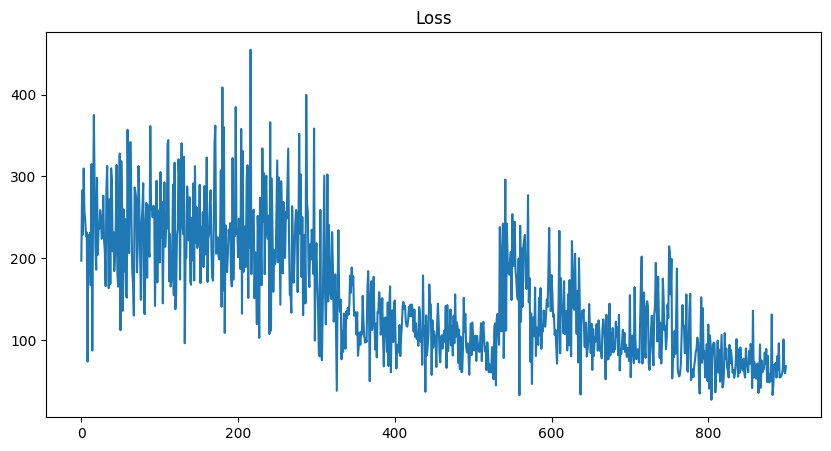

In [ ]:
_, ax = plt.subplots(1,1,figsize=(10,5))
ax.set_title('Loss')
ax.plot(outlier_loss)